In [1]:
import numpy as np
import pandas as pd
import math as mt
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
import csv

import vector
from tqdm import tqdm

import pylorentz

<BarContainer object of 1 artists>

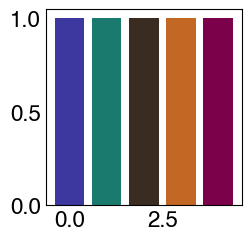

In [254]:
plt.style.use('_mpl-gallery-nogrid')

#plt.style.use('mystyle.mplstyle')

palette_balanced = [
    "#3C38A0",  # deep indigo
#    "#7152B8",  # royal purple (new)
    "#1B7A6E",  # lighter teal
    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_balanced)

plt.bar(0, 1, color = 'C0')
plt.bar(1, 1, color = 'C1')
plt.bar(2, 1, color = 'C2')
plt.bar(3, 1, color = 'C3')
plt.bar(4, 1, color = 'C4')

In [3]:
## some scale factors and constant you might use

## mass square of muon: m_muon^2 (in GeV)
sqm1 = (0.105658) * (0.105658)
## mass square of electron: m_e^2 (in GeV)
sqme = (0.0005109989) * (0.0005109989)
## mass of Z boson (in GeV)
mZ = 91.1876


## constants for the scale factor of MC. The MC is produced at a certain cross section\
## with certain number of events. To increase statistics, the event numbers generated are usually very large,\
## therefore a scale factor is needed to apply on the MC to make them agree with data.
## Scale factor for each MC component is: lumi * xsec / nevt, as provided below

## Luminosity of each year
lumi12 = 11580.
lumi11 = 2330.

## MC cross section of each process
xsecZZ412 = 0.107
xsecZZ2mu2e12 = 0.249
xsecZZ411 = 0.093
xsecZZ2mu2e11 = 0.208

xsecTTBar12 = 200.
xsecTTBar11 = 19.504

xsecDY5012 = 2955.
xsecDY1012 = 10.742
xsecDY5011 = 2475.
xsecDY1011 = 9507.
  
scalexsecHZZ12 = 0.0065
scalexsecHZZ11 = 0.0057

## Number of MC Events generated for each process
nevtZZ4mu12 = 1499064
nevtZZ4e12 = 1499093
nevtZZ2mu2e12 = 1497445
nevtHZZ12 = 299973 
nevtTTBar12 = 6423106
nevtDY5012 = 29426492
nevtDY1012 = 6462290
  
nevtZZ4mu11 = 1447136
nevtZZ4e11 = 1493308
nevtZZ2mu2e11 = 1479879
nevtHZZ11 = 299683
nevtTTBar11 = 9771205
nevtDY5011 = 36408225
nevtDY1011 = 39909640


labels = [r'$m_{H}$ = 125 GeV', r'ZZ $\rightarrow$ 4l', r'Z/$\gamma^{*}$ + X', r'$t\bar{t}$']
colors = ['r','b','g','gray']
scales_higgs = [lumi11*scalexsecHZZ11/nevtHZZ11, lumi12*scalexsecHZZ12/nevtHZZ12]
scales_zz = [lumi11*xsecZZ411/nevtZZ4mu11, lumi11*xsecZZ2mu2e11/nevtZZ2mu2e11, lumi11*xsecZZ411/nevtZZ4e11,\
             lumi12*xsecZZ412/nevtZZ4mu12, lumi12*xsecZZ2mu2e12/nevtZZ2mu2e12, lumi12*xsecZZ412/nevtZZ4e12]
scales_dy = [lumi11*xsecDY1011/nevtDY1011, lumi11*xsecDY5011/nevtDY5011, \
             lumi12*xsecDY1012/nevtDY1012, lumi11*xsecDY5012/nevtDY5012]
scales_tt = [lumi11*xsecTTBar11/nevtTTBar11, lumi12*xsecTTBar12/nevtTTBar12]

In [4]:
### open the files ###
# read datalist of each year and combine to one 
data_year  = [pd.read_csv('data/clean_data_2011.csv',index_col=None, header=0)]
data_year += [pd.read_csv('data/clean_data_2012.csv',index_col=None, header=0)]
data = pd.concat(data_year,axis=0,ignore_index=True)


# read MClist of each process and each year
mc_higgs_11 = pd.read_csv('MC/higgs2011.csv',index_col=None, header=0)
mc_higgs_12 = pd.read_csv('MC/higgs2012.csv',index_col=None, header=0)
## ZZ*
mc_zz4mu_11 = pd.read_csv('MC/zzto4mu2011.csv',index_col=None, header=0)
mc_zz2mu2e_11 = pd.read_csv('MC/zzto2mu2e2011.csv',index_col=None, header=0)
mc_zz4e_11 = pd.read_csv('MC/zzto4e2011.csv',index_col=None, header=0)

mc_zz4mu_12 = pd.read_csv('MC/zzto4mu2012.csv',index_col=None, header=0)
mc_zz2mu2e_12 = pd.read_csv('MC/zzto2mu2e2012.csv',index_col=None, header=0)
mc_zz4e_12 = pd.read_csv('MC/zzto4e2012.csv',index_col=None, header=0)
## Drell-Yan
mc_dy10_11 = pd.read_csv('MC/dy1050_2011.csv',index_col=None, header=0)
mc_dy50_11 = pd.read_csv('MC/dy50_2011.csv',index_col=None, header=0)
mc_dy10_12 = pd.read_csv('MC/dy1050_2012.csv',index_col=None, header=0)
mc_dy50_12 = pd.read_csv('MC/dy50_2012.csv',index_col=None, header=0)
## ttbar
mc_ttbar_11 = pd.read_csv('MC/ttbar2011.csv',index_col=None, header=0)
mc_ttbar_12 = pd.read_csv('MC/ttbar2012.csv',index_col=None, header=0)


mc_list = [mc_higgs_11, mc_higgs_12, 
           mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12, 
           mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12,
           mc_ttbar_11, mc_ttbar_12]

In [5]:
# --- Utility functions ---
def pt(px, py):
    return np.sqrt(px**2 + py**2)

def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def delta_R(df, i, j):
    dphi = (df[f'phi{i}'] - df[f'phi{j}'] + np.pi) % (2 * np.pi) - np.pi
    deta = df[f'eta{i}'] - df[f'eta{j}']
    return np.sqrt(deta**2 + dphi**2)

In [6]:
def identify_event(df):
    """Vectorized reconstruction of Z candidates for 4-lepton events."""
    
    def inv_mass(E1, px1, py1, pz1, E2, px2, py2, pz2):
        return np.sqrt(np.maximum(0, (E1 + E2)**2 - ((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)))
    
    pid1 = df["PID1"] 
    pid2 = df["PID2"] 
    pid3 = df["PID3"] 
    pid4 = df["PID4"] 

#    print(pid1, pid2, pid3, pid4)

    evt_type = np.zeros(df.shape[0])

    conserve = ((pid1+pid2+pid3+pid4) == 0) & ((df["Q1"]+df["Q2"]+df["Q3"]+df["Q4"]) == 0)

    mask_2mu2e = conserve & (np.abs(pid1)+np.abs(pid2)+np.abs(pid3)+np.abs(pid4) == 48)

    mask_4e = conserve & (np.abs(pid1) == 11) & (np.abs(pid2) == 11) & (np.abs(pid3) == 11) & (np.abs(pid4) == 11)
    
    mask_4mu = conserve & (np.abs(pid1) == 13) & (np.abs(pid2) == 13) & (np.abs(pid3) == 13) & (np.abs(pid4) == 13) 

    evt_type[mask_2mu2e] = 1
    evt_type[mask_4e] = 2
    evt_type[mask_4mu] = 3

#    print(evt_type)

    df['event_type'] = evt_type

    return df


In [7]:
data = identify_event(data)
for mc in mc_list:
    mc = identify_event(mc)

In [8]:
def compute_mz(df):
    """Vectorized reconstruction of Z candidates for 4-lepton events."""
    
    def inv_mass(E1, px1, py1, pz1, E2, px2, py2, pz2):
        return np.sqrt(np.maximum(0, (E1 + E2)**2 - ((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)))

    pid1 = df["PID1"] 
    pid2 = df["PID2"] 
    pid3 = df["PID3"] 
    pid4 = df["PID4"]
    
    mask12 = (pid1+pid2 == 0) & (pid3+pid4 == 0) 
    mask13 = (pid1+pid3 == 0) & (pid2+pid4 == 0) 
    mask14 = (pid1+pid4 == 0) & (pid2+pid3 == 0) 

    df.loc[mask12, "mz1_c1"] = inv_mass(
        df.loc[mask12, "E1"], df.loc[mask12, "px1"], df.loc[mask12, "py1"], df.loc[mask12, "pz1"],
        df.loc[mask12, "E2"], df.loc[mask12, "px2"], df.loc[mask12, "py2"], df.loc[mask12, "pz2"]
    )
    
    df.loc[mask12, "mz2_c1"] = inv_mass(
        df.loc[mask12, "E3"], df.loc[mask12, "px3"], df.loc[mask12, "py3"], df.loc[mask12, "pz3"],
        df.loc[mask12, "E4"], df.loc[mask12, "px4"], df.loc[mask12, "py4"], df.loc[mask12, "pz4"]
    )

    df.loc[mask13, "mz1_c2"] = inv_mass(
        df.loc[mask13, "E1"], df.loc[mask13, "px1"], df.loc[mask13, "py1"], df.loc[mask13, "pz1"],
        df.loc[mask13, "E3"], df.loc[mask13, "px3"], df.loc[mask13, "py3"], df.loc[mask13, "pz3"]
    )
    
    df.loc[mask13, "mz2_c2"] = inv_mass(
        df.loc[mask13, "E2"], df.loc[mask13, "px2"], df.loc[mask13, "py2"], df.loc[mask13, "pz2"],
        df.loc[mask13, "E4"], df.loc[mask13, "px4"], df.loc[mask13, "py4"], df.loc[mask13, "pz4"]
    )

    df.loc[mask14, "mz1_c3"] = inv_mass(
        df.loc[mask14, "E1"], df.loc[mask14, "px1"], df.loc[mask14, "py1"], df.loc[mask14, "pz1"],
        df.loc[mask14, "E4"], df.loc[mask14, "px4"], df.loc[mask14, "py4"], df.loc[mask14, "pz4"]
    )
    
    df.loc[mask14, "mz2_c3"] = inv_mass(
        df.loc[mask14, "E2"], df.loc[mask14, "px2"], df.loc[mask14, "py2"], df.loc[mask14, "pz2"],
        df.loc[mask14, "E3"], df.loc[mask14, "px3"], df.loc[mask14, "py3"], df.loc[mask14, "pz3"]
    )

    return df

In [9]:
data = compute_mz(data)
for mc in mc_list:
    mc = compute_mz(mc)

In [10]:
# --- Object selection ---
def object_selection(df):
    # Compute per-particle pt values
    for i in range(1, 5):
        df[f'pt{i}'] = pt(df[f'px{i}'], df[f'py{i}'])

    # Boolean masks for each lepton
    mu_mask = lambda i: (df[f'PID{i}'].abs() == 13) & (df[f'pt{i}'] > 5) & (np.abs(df[f'eta{i}']) < 2.4)
    el_mask = lambda i: (df[f'PID{i}'].abs() == 11) & (df[f'pt{i}'] > 7) & (np.abs(df[f'eta{i}']) < 2.5)

    # Apply object selection across all 4 leptons
    df['PassObj'] = (
        (mu_mask(1) | el_mask(1)) &
        (mu_mask(2) | el_mask(2)) &
        (mu_mask(3) | el_mask(3)) &
        (mu_mask(4) | el_mask(4))
    )

    return df
# --- Event selection ---

def event_selection(df):

    # Charge + flavor conservation
    conserve = df['event_type'] != 0

    # Apply final event selection mask
    df['PassEvt'] = conserve & df['PassObj'] 

    return df

In [11]:
### Apply object selection and event selection to data and each MC process###

data = event_selection(object_selection(data))

for mc in mc_list:
    mc = event_selection(object_selection(mc))

# creat a combined list of MC to study the shape
mc_higgs = [mc_higgs_11, mc_higgs_12]
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
mc_dy = [mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12]
mc_tt = [mc_ttbar_11, mc_ttbar_12]

mc_sig = pd.concat(mc_higgs,axis=0,ignore_index=True)
mc_bkg_zz = pd.concat(mc_zz,axis=0,ignore_index=True)
mc_bkg_dy = pd.concat(mc_dy,axis=0,ignore_index=True)
mc_bkg_tt = pd.concat(mc_tt,axis=0,ignore_index=True)

## For Selections:
mc_all = [mc_higgs, mc_zz, mc_dy, mc_tt]

In [12]:
np.mean(data['event_type'])

np.float64(1.433553597650514)

In [13]:
data.keys()

Index(['Run', 'Event', 'PID1', 'Q1', 'E1', 'px1', 'py1', 'pz1', 'eta1', 'phi1',
       'PID2', 'Q2', 'E2', 'px2', 'py2', 'pz2', 'eta2', 'phi2', 'PID3', 'Q3',
       'E3', 'px3', 'py3', 'pz3', 'eta3', 'phi3', 'PID4', 'Q4', 'E4', 'px4',
       'py4', 'pz4', 'eta4', 'phi4', 'event_type', 'mz1_c1', 'mz2_c1',
       'mz1_c2', 'mz2_c2', 'mz1_c3', 'mz2_c3', 'pt1', 'pt2', 'pt3', 'pt4',
       'PassObj', 'PassEvt'],
      dtype='object')

In [14]:
def InvMass_4l(lists):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = lists['E1'] + lists['E2'] + lists['E3'] + lists['E4']
    px_tot = lists['px1'] + lists['px2'] + lists['px3'] + lists['px4']
    py_tot = lists['py1'] + lists['py2'] + lists['py3'] + lists['py4']
    pz_tot = lists['pz1'] + lists['pz2'] + lists['pz3'] + lists['pz4']
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

def HistInvMass4l(lis, scales, rmin, rmax, nbins):
    hist_lis = []
    for i,pro in enumerate(lis):
        invM = InvMass_4l(pro)
        hist, bins = np.histogram(invM, bins = nbins, range = (rmin,rmax))
        hist = hist * scales[i]
        hist_lis.append(hist)
    return sum(hist_lis)

In [15]:
def calculate_M4l(df):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = df['E1'] + df['E2'] + df['E3'] + df['E4']
    px_tot = df['px1'] + df['px2'] + df['px3'] + df['px4']
    py_tot = df['py1'] + df['py2'] + df['py3'] + df['py4']
    pz_tot = df['pz1'] + df['pz2'] + df['pz3'] + df['pz4']
    df['m4l'] = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    return df

In [16]:
data = calculate_M4l(data)

for mc in mc_list:
    mc = calculate_M4l(mc)

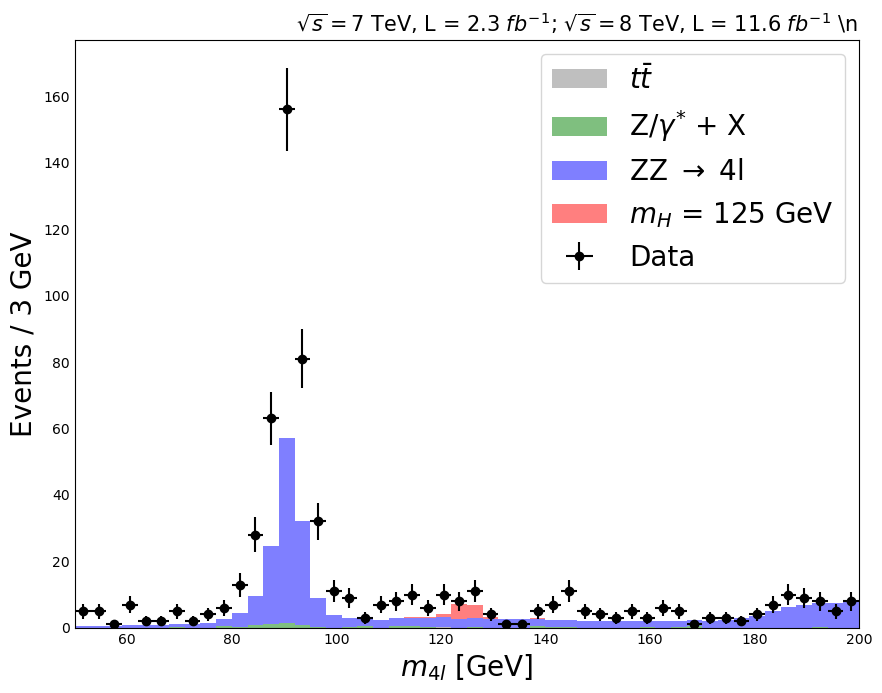

In [17]:
mc_higgs = [mc_higgs_11.query('PassEvt == True'), mc_higgs_12.query('PassEvt == True')]
mc_zz = [mc_zz4mu_11.query('PassEvt == True'), mc_zz2mu2e_11.query('PassEvt == True'), mc_zz4e_11.query('PassEvt == True'), mc_zz4mu_12.query('PassEvt == True'), mc_zz2mu2e_12.query('PassEvt == True'), mc_zz4e_12.query('PassEvt == True')]
mc_dy = [mc_dy10_11.query('PassEvt == True'), mc_dy50_11.query('PassEvt == True'), mc_dy10_12.query('PassEvt == True'), mc_dy50_12.query('PassEvt == True')]
mc_tt = [mc_ttbar_11.query('PassEvt == True'), mc_ttbar_12.query('PassEvt == True')]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data.query('PassEvt == True'))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$ \n', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(rmin,rmax)
plt.legend(fontsize = 20)

plt.show()

In [18]:
mc_shape_list = [mc_sig, mc_bkg_zz, mc_bkg_dy, mc_bkg_tt]

for mc in mc_shape_list:
    mc = mc.query('PassEvt == True')

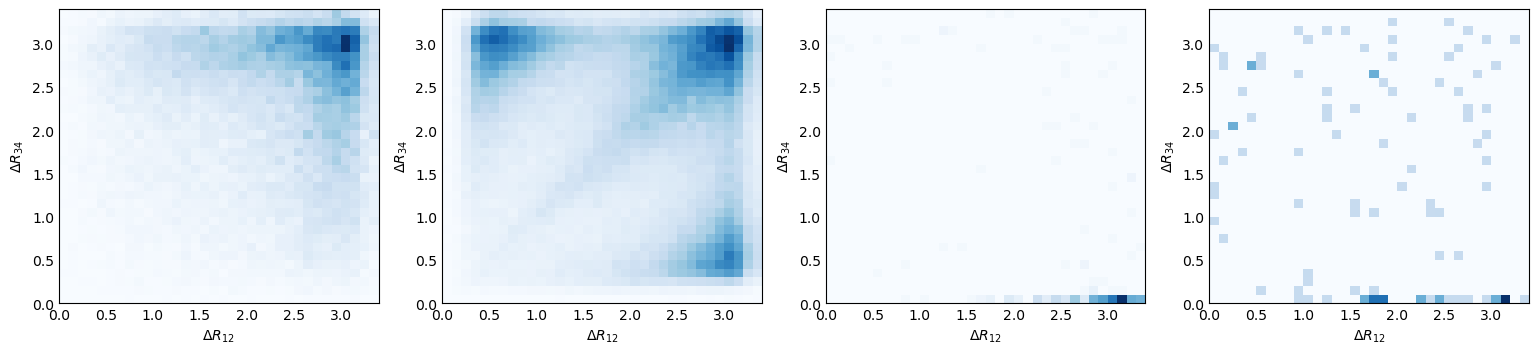

In [19]:
bins = (np.arange(0, 3.5, 0.1), np.arange(0, 3.5, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('event_type == 1'), 1, 2), 
           delta_R(mc_sig.query('event_type == 1'), 3, 4),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{12}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('event_type == 1'), 1, 2), 
           delta_R(mc_bkg_zz.query('event_type == 1'), 3, 4),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{12}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('event_type == 1'), 1, 2), 
           delta_R(mc_bkg_dy.query('event_type == 1'), 3, 4),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{12}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('event_type == 1'), 1, 2), 
           delta_R(mc_bkg_tt.query('event_type == 1'), 3, 4),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{12}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

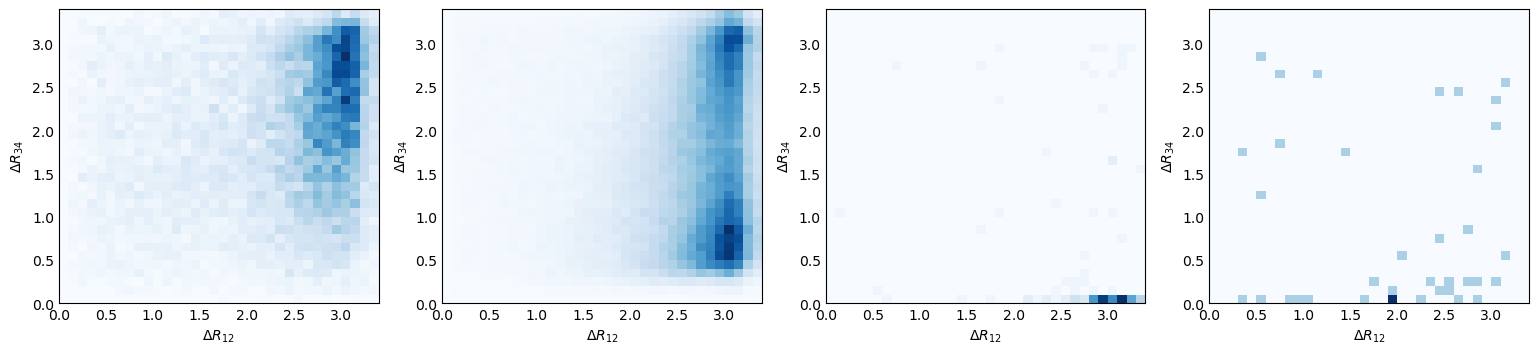

In [20]:
bins = (np.arange(0, 3.5, 0.1), np.arange(0, 3.5, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('event_type == 2'), 1, 2), 
           delta_R(mc_sig.query('event_type == 2'), 3, 4),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{12}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('event_type == 2'), 1, 2), 
           delta_R(mc_bkg_zz.query('event_type == 2'), 3, 4),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{12}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('event_type == 2'), 1, 2), 
           delta_R(mc_bkg_dy.query('event_type == 2'), 3, 4),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{12}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('event_type == 2'), 1, 2), 
           delta_R(mc_bkg_tt.query('event_type == 2'), 3, 4),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{12}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

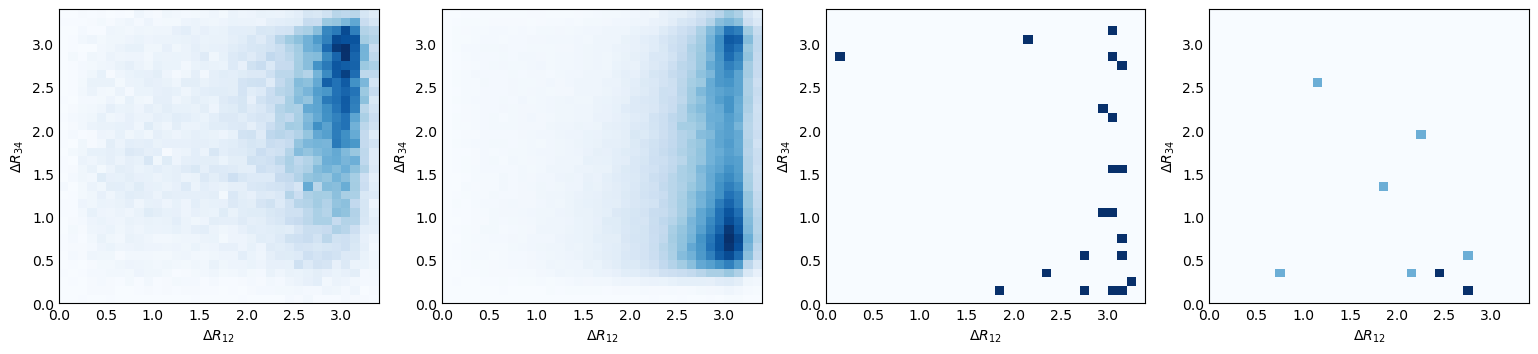

In [21]:
bins = (np.arange(0, 3.5, 0.1), np.arange(0, 3.5, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('event_type == 3'), 1, 2), 
           delta_R(mc_sig.query('event_type == 3'), 3, 4),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{12}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('event_type == 3'), 1, 2), 
           delta_R(mc_bkg_zz.query('event_type == 3'), 3, 4),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{12}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('event_type == 3'), 1, 2), 
           delta_R(mc_bkg_dy.query('event_type == 3'), 3, 4),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{12}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('event_type == 3'), 1, 2), 
           delta_R(mc_bkg_tt.query('event_type == 3'), 3, 4),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{12}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

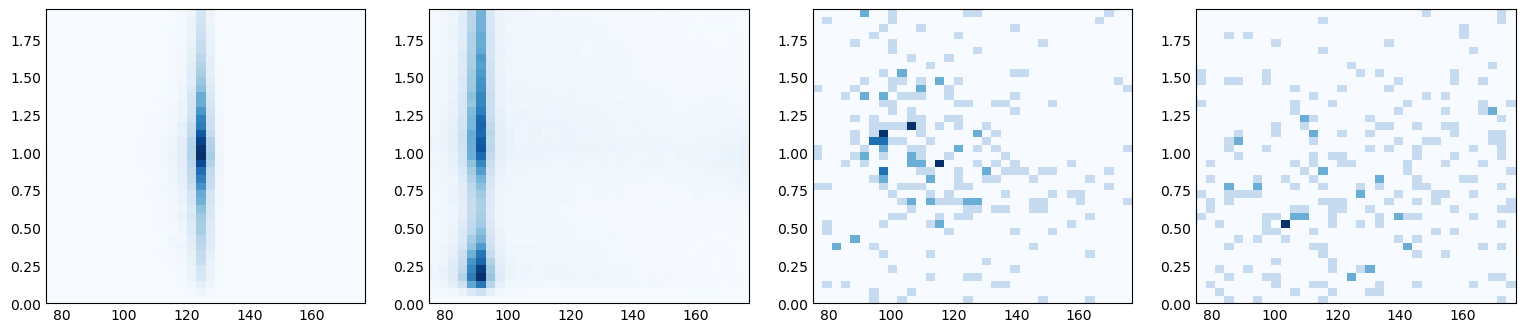

In [22]:
bins = (np.arange(75,180,3), np.arange(0, 2, 0.05))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(InvMass_4l(mc_sig), 
           delta_R(mc_sig, 1, 2)/delta_R(mc_sig, 3, 4),
           bins, 
           density = True, label = labels[0])


ax1.hist2d(InvMass_4l(mc_bkg_zz), 
           delta_R(mc_bkg_zz, 1, 2)/delta_R(mc_bkg_zz, 3, 4),
           bins, 
           density = True, label = labels[1])


ax2.hist2d(InvMass_4l(mc_bkg_dy), 
           delta_R(mc_bkg_dy, 1, 2)/delta_R(mc_bkg_dy, 3, 4),
           bins, 
           density = True, label = labels[2])

ax3.hist2d(InvMass_4l(mc_bkg_tt), 
           delta_R(mc_bkg_tt, 1, 2)/delta_R(mc_bkg_tt, 3, 4),
           bins, 
           density = True, label = labels[3])

#plt.legend()
plt.show()

In [23]:
print(min(delta_R(mc_sig, 1, 2)))
print(np.mean(delta_R(mc_sig, 1, 2)))
print(max(delta_R(mc_sig, 1, 2)))

print(min(mc_sig['mz1_c1']))
print(max(mc_sig['mz1_c1']))

print(min(mc_sig['mz2_c1']))
print(max(mc_sig['mz2_c1']))

0.0002860069929216442
2.4299109950872726
5.318434215175731
0.2856024760048148
276.06552020582
0.012728821469657732
321.4663225467949


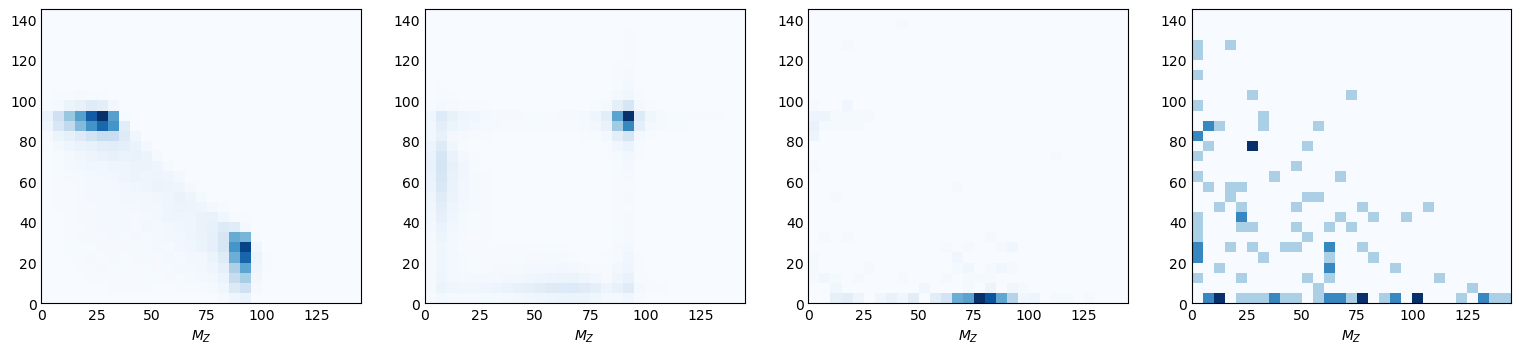

In [24]:
#### The data is ordered such that if 2mu2e or 2e2mu then the only pairing is 12, 34

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

bins2d = (np.arange(0,150,5), np.arange(0,150,5))

ax0.hist2d(
    mc_sig.query('event_type == 1')['mz1_c1'],
    mc_sig.query('event_type == 1')['mz2_c1'],
           bins2d, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$M_Z$")
#ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(
    mc_bkg_zz.query('event_type == 1')['mz1_c1'],
    mc_bkg_zz.query('event_type == 1')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$M_Z$")
#ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(
    mc_bkg_dy.query('event_type == 1')['mz1_c1'],
    mc_bkg_dy.query('event_type == 1')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$M_Z$")
#ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(
    mc_bkg_tt.query('event_type == 1')['mz1_c1'], 
    mc_bkg_tt.query('event_type == 1')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$M_Z$")
#ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

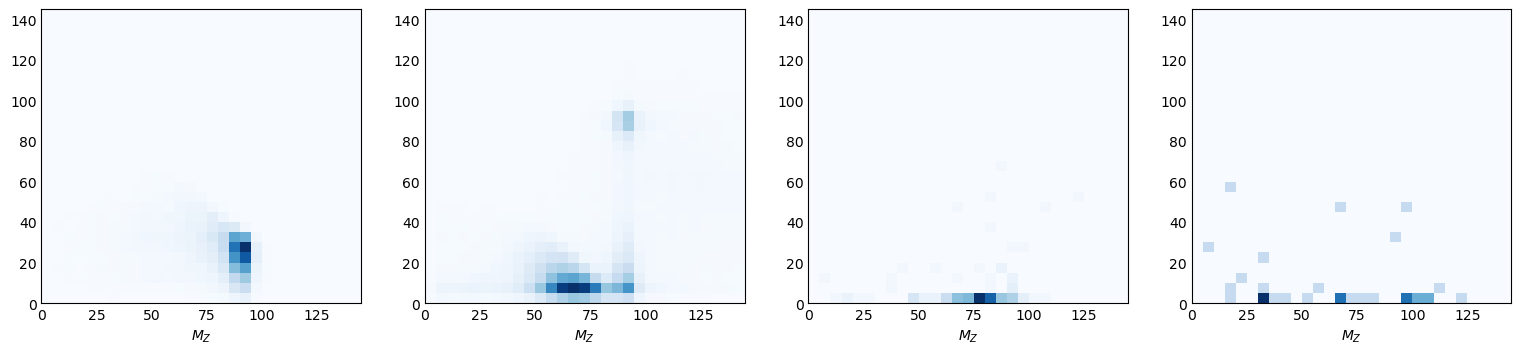

In [25]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

bins2d = (np.arange(0,150,5), np.arange(0,150,5))

ax0.hist2d(
    mc_sig.query('event_type == 2')['mz1_c1'],
    mc_sig.query('event_type == 2')['mz2_c1'],
           bins2d, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$M_Z$")
#ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(
    mc_bkg_zz.query('event_type == 2')['mz1_c1'],
    mc_bkg_zz.query('event_type == 2')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$M_Z$")
#ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(
    mc_bkg_dy.query('event_type == 2')['mz1_c1'],
    mc_bkg_dy.query('event_type == 2')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$M_Z$")
#ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(
    mc_bkg_tt.query('event_type == 2')['mz1_c1'], 
    mc_bkg_tt.query('event_type == 2')['mz2_c1'], 
           bins2d, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$M_Z$")
#ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

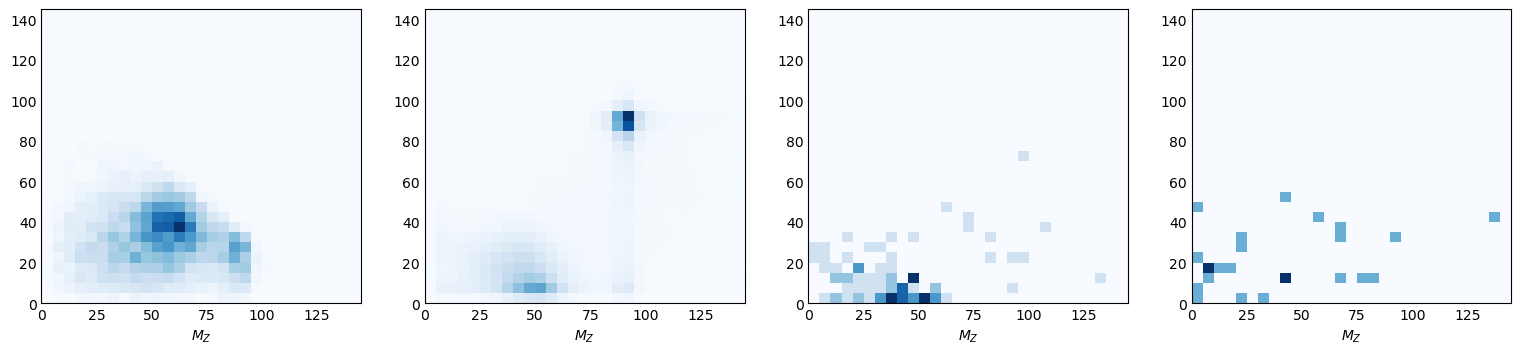

In [26]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

bins2d = (np.arange(0,150,5), np.arange(0,150,5))

ax0.hist2d(
    mc_sig.query('event_type == 2')['mz1_c2'],
    mc_sig.query('event_type == 2')['mz2_c2'],
           bins2d, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$M_Z$")
#ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(
    mc_bkg_zz.query('event_type == 2')['mz1_c2'],
    mc_bkg_zz.query('event_type == 2')['mz2_c2'], 
           bins2d, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$M_Z$")
#ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(
    mc_bkg_dy.query('event_type == 2')['mz1_c2'],
    mc_bkg_dy.query('event_type == 2')['mz2_c2'], 
           bins2d, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$M_Z$")
#ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(
    mc_bkg_tt.query('event_type == 2')['mz1_c2'], 
    mc_bkg_tt.query('event_type == 2')['mz2_c2'], 
           bins2d, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$M_Z$")
#ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

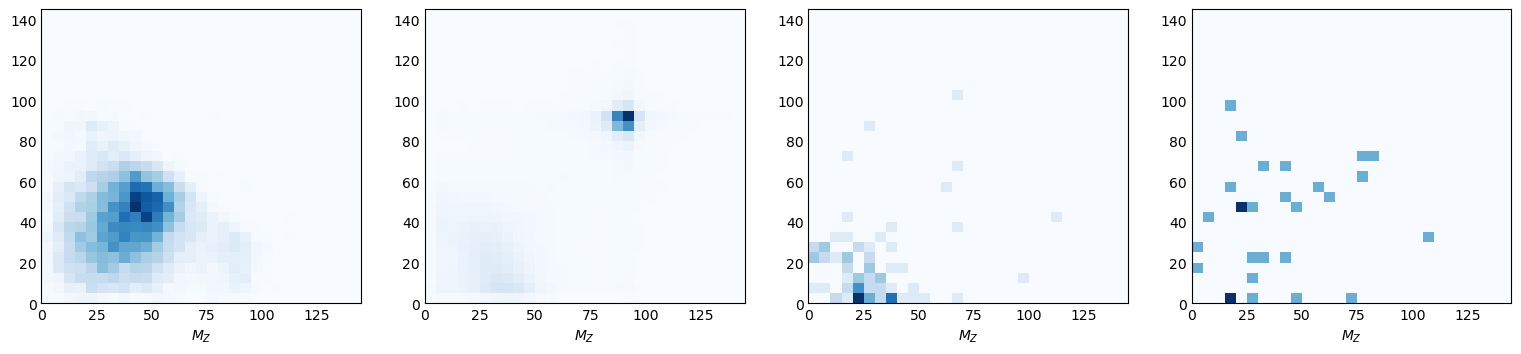

In [27]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

bins2d = (np.arange(0,150,5), np.arange(0,150,5))

ax0.hist2d(
    mc_sig.query('event_type == 2')['mz1_c3'],
    mc_sig.query('event_type == 2')['mz2_c3'],
           bins2d, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$M_Z$")
#ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(
    mc_bkg_zz.query('event_type == 2')['mz1_c3'],
    mc_bkg_zz.query('event_type == 2')['mz2_c3'], 
           bins2d, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$M_Z$")
#ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(
    mc_bkg_dy.query('event_type == 2')['mz1_c3'],
    mc_bkg_dy.query('event_type == 2')['mz2_c3'], 
           bins2d, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$M_Z$")
#ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(
    mc_bkg_tt.query('event_type == 2')['mz1_c3'], 
    mc_bkg_tt.query('event_type == 2')['mz2_c3'], 
           bins2d, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$M_Z$")
#ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

In [28]:
def apply_event_selection(df):

    # Charge + flavor conservation
    conserve = df['event_type'] != 0

    angular = (delta_R(df, 1, 2) > 0.5) & (delta_R(df, 3, 4)>0.5) 

    Zmass =  ( 
        ((df["mz1_c1"].between(40, 120)) & (df["mz2_c1"].between(12, 120)) ) |
        ((df["mz2_c1"].between(40, 120)) & (df["mz1_c1"].between(12, 120)) ) |
        ((df["mz1_c2"].between(40, 120)) & (df["mz2_c2"].between(12, 120)) ) |
        ((df["mz2_c2"].between(40, 120)) & (df["mz1_c2"].between(12, 120)) ) |
        ((df["mz1_c3"].between(40, 120)) & (df["mz2_c3"].between(12, 120)) ) |
        ((df["mz2_c3"].between(40, 120)) & (df["mz1_c3"].between(12, 120)) )
    )
    
    # Apply final event selection mask
    df['PassSel'] = (conserve 
                     & df['PassObj'] 
                     & angular 
                     & Zmass
                    )  # you can extend with additional cuts if needed

    return df

### Apply object selection and event selection to data and each MC process###
data_obj_sel = object_selection(data)
data_evt_sel = apply_event_selection(data_obj_sel)

print('eff on data: ' , (data.query('PassSel == True').shape[0]/ data.shape[0]))

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = apply_event_selection(object_selection(pro))

print('eff on signal: ' , (mc_higgs_11.query('PassSel == True').shape[0]+ mc_higgs_12.query('PassSel == True').shape[0])/(mc_higgs_11.shape[0]+mc_higgs_12.shape[0]))

eff on data:  0.11490455212922174
eff on signal:  0.792224449761797


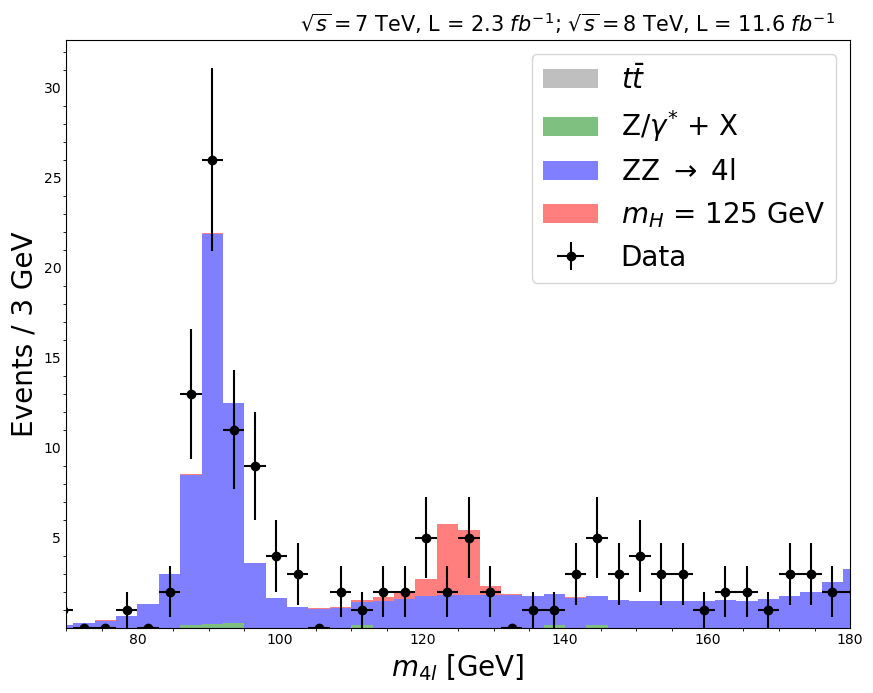

In [29]:
mc_higgs = [mc_higgs_11.query('PassSel == True'), mc_higgs_12.query('PassSel == True')]
mc_zz = [mc_zz4mu_11.query('PassSel == True'), mc_zz2mu2e_11.query('PassSel == True'), mc_zz4e_11.query('PassSel == True'), mc_zz4mu_12.query('PassSel == True'), mc_zz2mu2e_12.query('PassSel == True'), mc_zz4e_12.query('PassSel == True')]
mc_dy = [mc_dy10_11.query('PassSel == True'), mc_dy50_11.query('PassSel == True'), mc_dy10_12.query('PassSel == True'), mc_dy50_12.query('PassSel == True')]
mc_tt = [mc_ttbar_11.query('PassSel == True'), mc_ttbar_12.query('PassSel == True')]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data_evt_sel.query('PassSel == True'))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(70,180)
plt.legend(fontsize = 20)
plt.minorticks_on()
plt.show()

In [30]:
import math
import pylorentz

def compute_boost(df):
    
    p = { }

    for i in range(1,5):
        p[f'{i}'] = pylorentz.Momentum4(df[f"E{i}"], df[f"px{i}"], df[f"py{i}"], df[f"pz{i}"])

    parent = p['1'] + p['2'] + p['3'] + p['4']

    for i in range(1,5):
        p[f'{i}'] = p[f'{i}'].boost(parent.p_x, parent.p_y, parent.p_z, beta=parent.p/parent.e)

    return p
    

In [31]:
cut = 'PassSel == True & event_type == 1'

p_data = compute_boost(data.query(cut))

mc_sig = pd.concat([mc_higgs_11.query(cut), mc_higgs_12.query(cut)], axis = 0)
p_sig = compute_boost(mc_sig.query(cut))

mc_bkg_zz = pd.concat(mc_zz, axis = 0)
p_bkg = compute_boost(mc_bkg_zz.query(cut))

<bound method Figure.show of <Figure size 1500x600 with 2 Axes>>

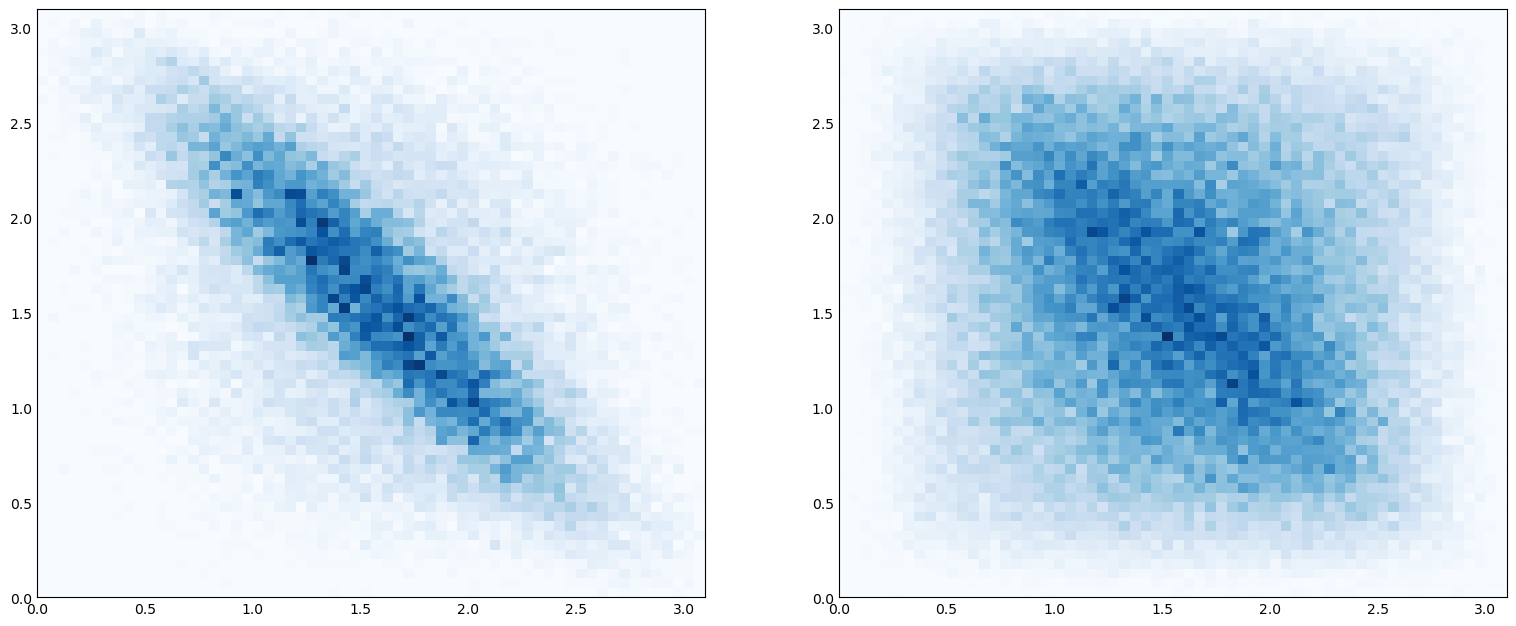

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(15)

bins = (np.arange(0,3.14, 0.05),np.arange(0,3.14, 0.05))
ax0.hist2d(
   p_sig['3'].theta  , p_sig['4'].theta, bins 
)


ax1.hist2d(
   p_bkg['3'].theta ,  p_bkg['4'].theta, bins
)

fig.show

<bound method Figure.show of <Figure size 1500x450 with 3 Axes>>

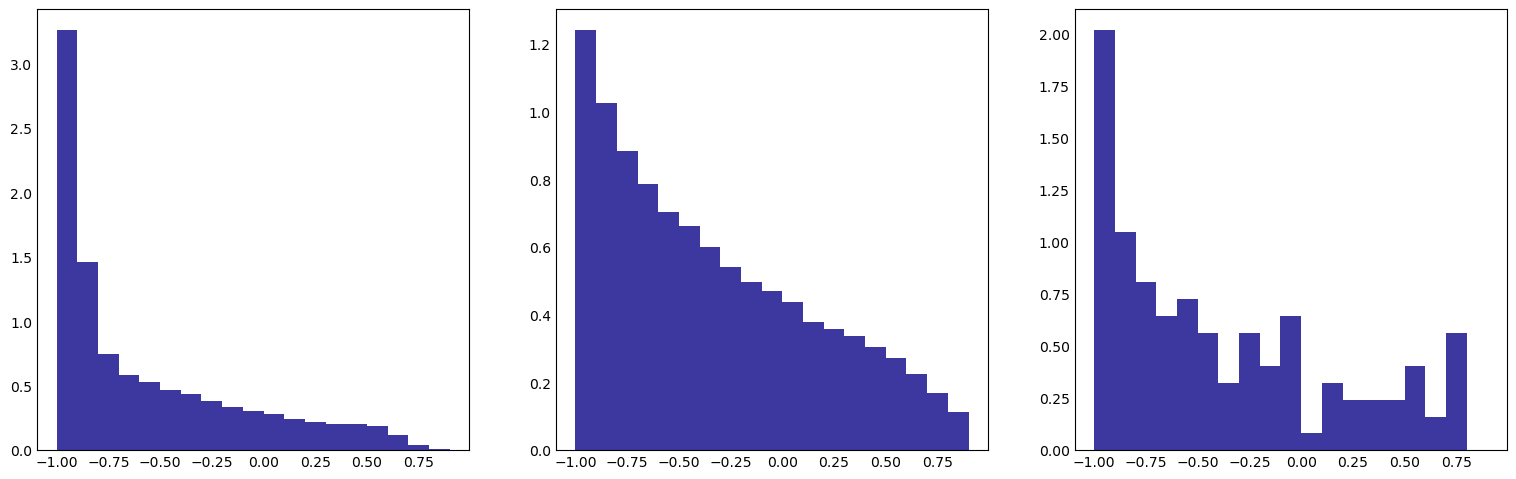

In [33]:
fig, (ax0,ax1, ax2) = plt.subplots(1,3)
fig.set_figheight(4.5)
fig.set_figwidth(15)

bins = (np.arange(-1,1, 0.1))
ax0.hist(
np.sin(p_sig['1'].theta) *np.sin(p_sig['2'].theta)*np.cos(p_sig['1'].phi - p_sig['2'].phi) + np.cos(p_sig['1'].theta)*np.cos(p_sig['2'].theta), 
bins,
density = True
) 


ax1.hist(
np.sin(p_bkg['1'].theta) *np.sin(p_bkg['2'].theta)*np.cos(p_bkg['1'].phi - p_bkg['2'].phi) + np.cos(p_bkg['1'].theta)*np.cos(p_bkg['2'].theta),
bins,
density = True
)

ax2.hist(
np.sin(p_data['1'].theta)*np.sin(p_data['2'].theta)*np.cos(p_data['1'].phi - p_data['2'].phi) + np.cos(p_data['1'].theta)*np.cos(p_data['2'].theta), 
bins,
density = True
)
fig.show

<bound method Figure.show of <Figure size 1500x450 with 3 Axes>>

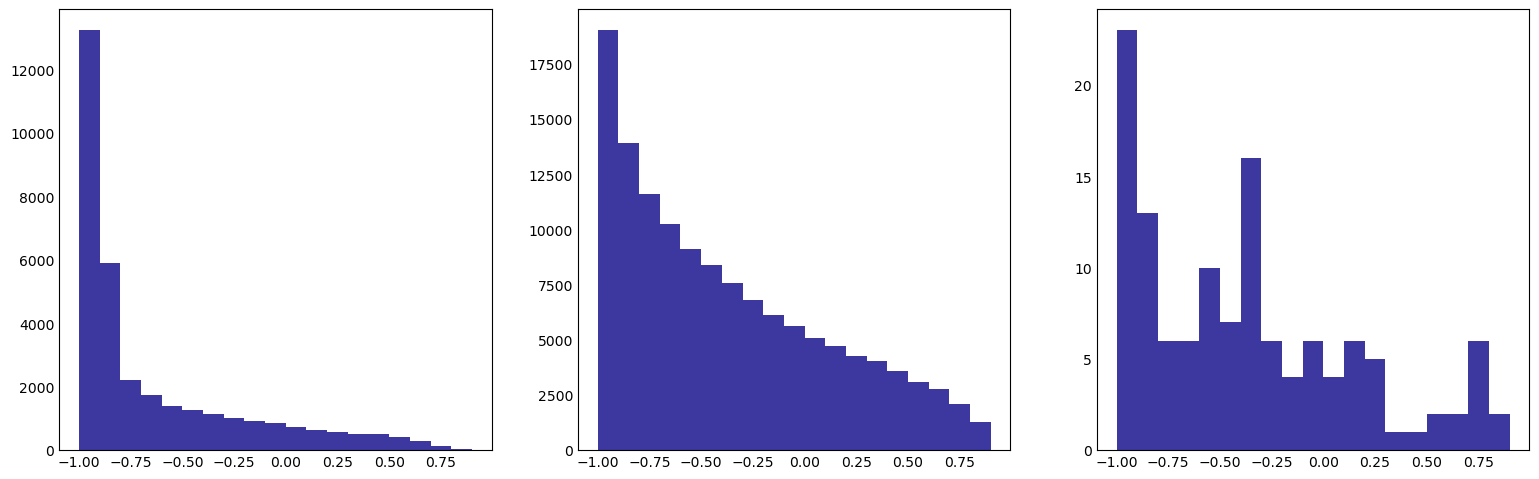

In [34]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3)
fig.set_figheight(4.5)
fig.set_figwidth(15)

bins = (np.arange(-1,1, 0.1))
ax0.hist(
np.sin(p_sig['3'].theta)*np.sin(p_sig['4'].theta)*np.cos(p_sig['3'].phi - p_sig['4'].phi) + np.cos(p_sig['3'].theta)*np.cos(p_sig['4'].theta), 
bins,
density = False
) 

ax1.hist(
np.sin(p_bkg['3'].theta)*np.sin(p_bkg['4'].theta)*np.cos(p_bkg['3'].phi - p_bkg['4'].phi) + np.cos(p_bkg['3'].theta)*np.cos(p_bkg['4'].theta), 
bins,
density = False
)

ax2.hist(
np.sin(p_data['3'].theta)*np.sin(p_data['4'].theta)*np.cos(p_data['3'].phi - p_data['4'].phi) + np.cos(p_data['3'].theta)*np.cos(p_data['4'].theta), 
bins,
density = False
)
fig.show

<bound method Figure.show of <Figure size 1500x450 with 3 Axes>>

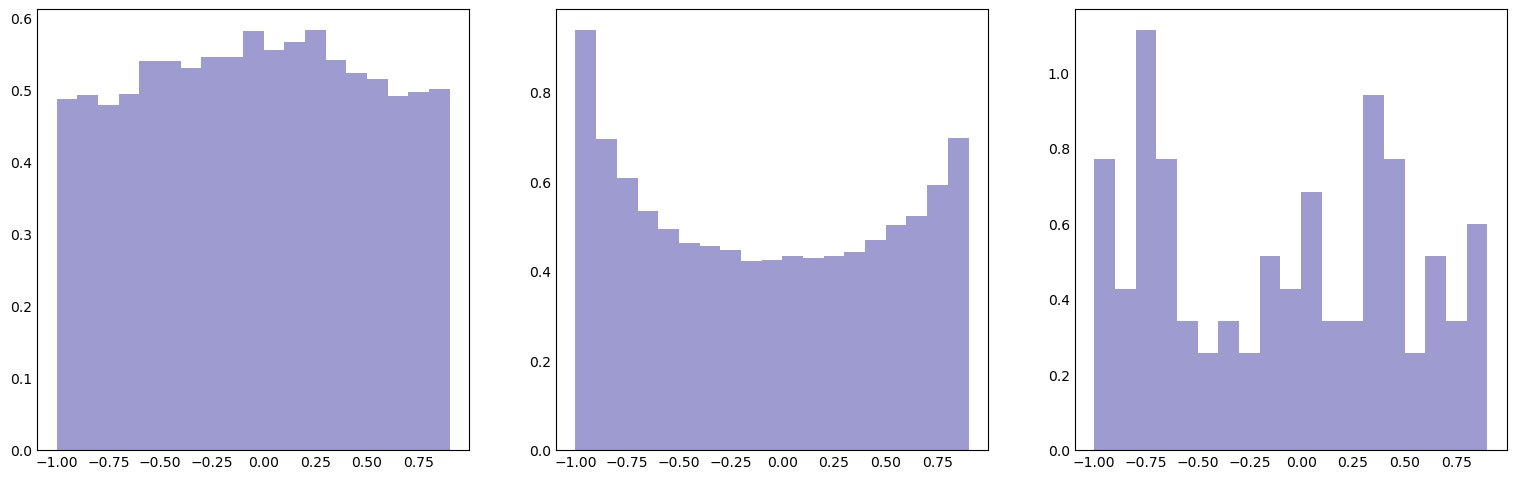

In [35]:
fig, (ax0,ax1, ax2) = plt.subplots(1,3)
fig.set_figheight(4.5)
fig.set_figwidth(15)

bins = (np.arange(-1,1, 0.1))
ax0.hist(
np.cos( (p_sig['1']+p_sig['2']).theta ), bins,
density = True, alpha = 0.5
) 

ax1.hist(
np.cos( (p_bkg['1']+p_bkg['2']).theta ), bins,
density = True, alpha = 0.5
)

ax2.hist(
np.cos( (p_data['1']+p_data['2']).theta ), bins,
density = True, alpha = 0.5
)
fig.show

<bound method Figure.show of <Figure size 1500x450 with 3 Axes>>

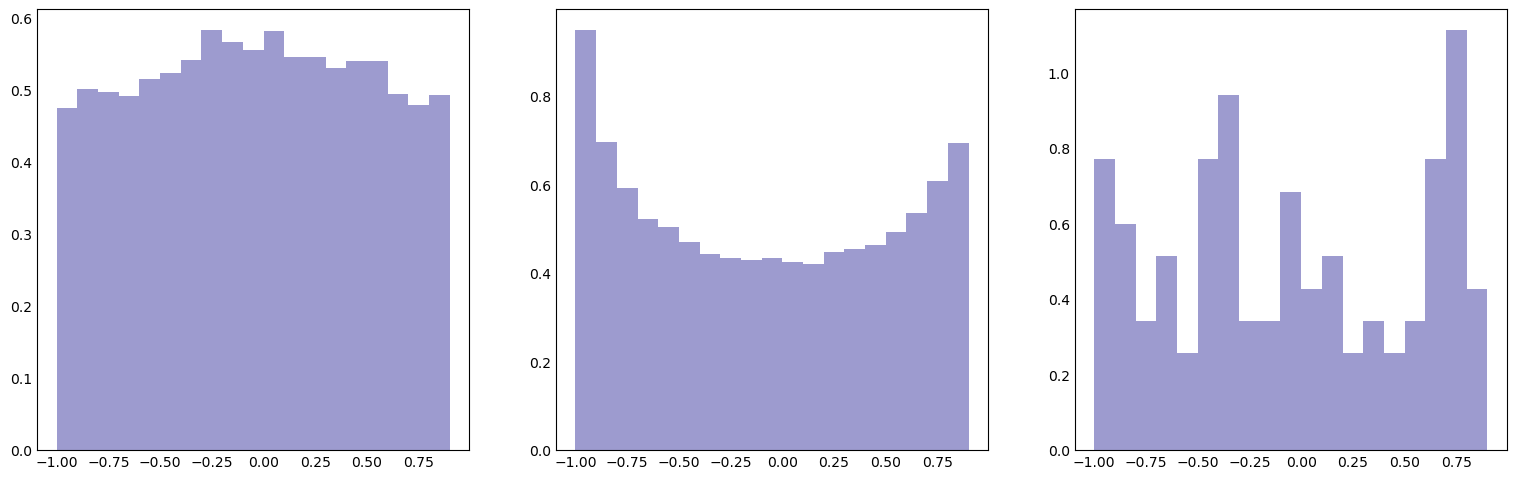

In [36]:
fig, (ax0,ax1, ax2) = plt.subplots(1,3)
fig.set_figheight(4.5)
fig.set_figwidth(15)

bins = (np.arange(-1,1, 0.1))
ax0.hist(
np.cos( (p_sig['3']+p_sig['4']).theta ), bins,
density = True, alpha = 0.5
) 

ax1.hist(
np.cos( (p_bkg['3']+p_bkg['4']).theta ), bins,
density = True, alpha = 0.5
)

ax2.hist(
np.cos( (p_data['3']+p_data['4']).theta ), bins,
density = True, alpha = 0.5
)
fig.show

<bound method Figure.show of <Figure size 1500x600 with 2 Axes>>

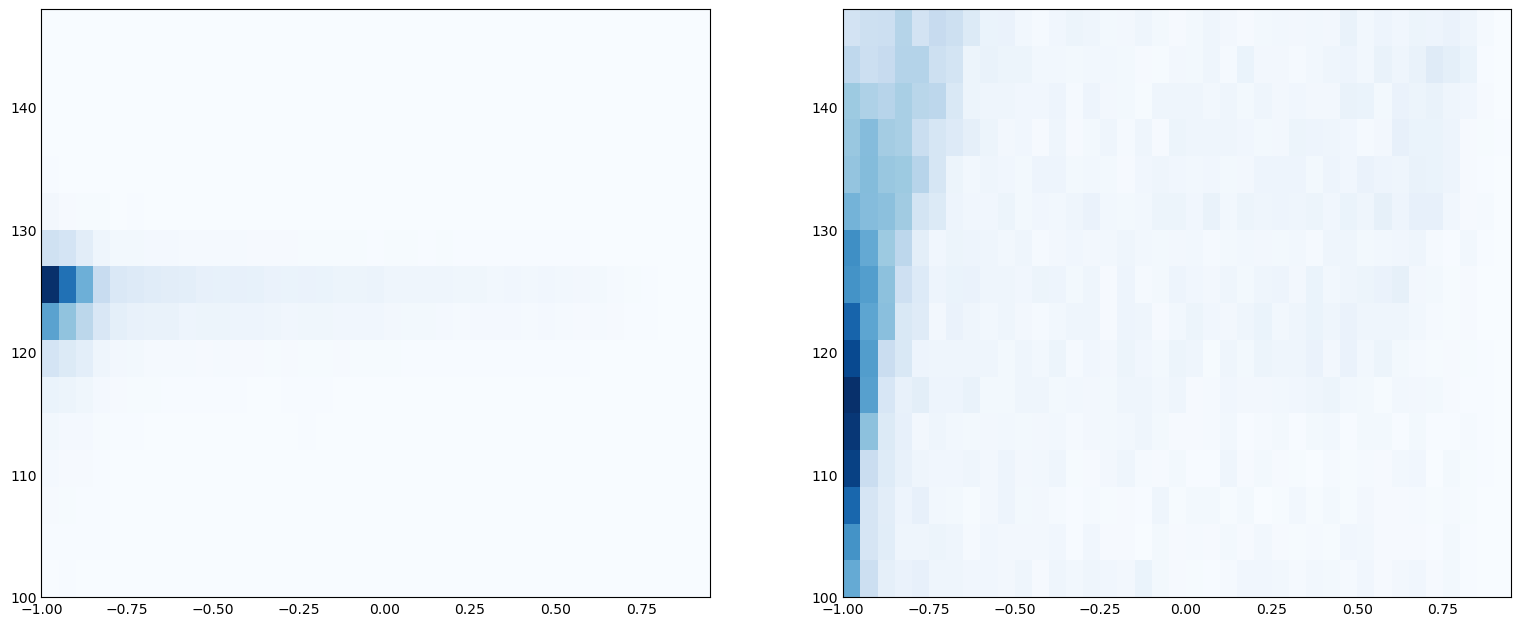

In [37]:
fig, (ax0,ax1) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(15)

bins = (np.arange(-1,1, 0.05), np.arange(100,150,3))
ax0.hist2d(
np.sin(p_sig['3'].theta)*np.sin(p_sig['4'].theta)*np.cos(p_sig['3'].phi - p_sig['4'].phi) + np.cos(p_sig['3'].theta)*np.cos(p_sig['4'].theta), 
mc_sig.query(cut)['m4l'],
bins,
density = True
) 

ax1.hist2d(
np.sin(p_bkg['3'].theta)*np.sin(p_bkg['4'].theta)*np.cos(p_bkg['3'].phi - p_bkg['4'].phi) + np.cos(p_bkg['3'].theta)*np.cos(p_bkg['4'].theta), 
mc_bkg_zz.query(cut)['m4l'],
bins,
density = True
)

fig.show

In [38]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import cross_val_score

In [89]:
def train_bdt(train_vars, signal_proxy, bkg_proxy):
    signal_df = signal_proxy
    background_df = bkg_proxy
    
    signal_df["category"]= 1 #Use 1 for signal
    background_df["category"] = 0 #use 0 for bkg
    training_data = pd.concat([signal_df[train_vars+['category']],background_df[train_vars+['category']]],copy=True,ignore_index=True,sort=False)
    training_data = training_data.sample(frac=1).reset_index(drop=True)
    training_data = training_data.dropna()
    
    mask = np.random.rand(len(training_data)) < 0.5
    _train_data = training_data.iloc[mask]
    _test_data = training_data.iloc[~mask]
    x,y = _train_data[train_vars],_train_data["category"]
    x_test,y_test = _test_data[train_vars],_test_data['category']
    
    var_list = train_vars
    
    min_len = min(signal_df.shape[0],background_df.shape[0])
    max_len = max(signal_df.shape[0],background_df.shape[0])
    
    
    imbalance = max_len/min_len
    kf = KFold(n_splits=5)
    x,y = training_data[var_list],training_data["category"]
    
    bdt = xgb.XGBClassifier(
            eta=0.4,
            objective='binary:logistic',
            scale_pos_weight=imbalance,
            ) 
    scores = cross_val_score(bdt,x,y,cv=kf,scoring='roc_auc')
    print(5*"#")
    print("Cross validation scores:")
    print(scores)
    print(5*"#")
    classifiers = []
    counter = 0
    for tri,tti in kf.split(x):
        counter+=1
        x_train,y_train = x.iloc[tri],y.iloc[tri]
        x_test,y_test = x.iloc[tti],y.iloc[tti]
        bdt = xgb.XGBClassifier(
            eta=0.4,
            objective='binary:logistic',
            scale_pos_weight=imbalance,
            )
        #bdt = CatBoostClassifier(silent=True)
        classifiers.append(bdt)
        classifiers[-1].fit(x_train,y_train)
        fig,ax = plt.subplots(1,1)
        mytype = 'xgb'
        proba_test = bdt.predict_proba(x_test)[:,1]
        fpr,tpr,_ = roc_curve(y_test,proba_test)
        area = auc(fpr,tpr)
        print(f'AUC: {area}')
        ax.plot(fpr,tpr,label = f'{mytype}')
        ax.set_xlabel(r'1 - Bkg rejection')
        ax.set_ylabel(r'Signal efficiency')
        ax.legend()
        fig.savefig(f'roc-{counter}.pdf')
        
        fig,ax = plt.subplots(1,1)
        sig_test = bdt.predict_proba(x_test[np.array(y_test,dtype='bool')])[:,1]
        sig_train = bdt.predict_proba(x[np.array(y,dtype='bool')])[:,1]
        bkg_test = bdt.predict_proba(x_test[~np.array(y_test,dtype='bool')])[:,1]
        bkg_train = bdt.predict_proba(x[~np.array(y,dtype='bool')])[:,1]
        
        ax.hist(sig_test,bins=50,color='red',density=True,label='Signal test',alpha=0.7)
        ax.hist(sig_train,bins=50,color='red',histtype='step',density=True,label='Signal train')
        
        ax.hist(bkg_test,bins=50,density=True,label='Background test',alpha=0.7,color='C0')
        ax.hist(bkg_train,bins=50,histtype='step',density=True,label='Background signal',alpha=0.7,color='C0')
        ax.set_xlabel(r'Classifier output')
        ax.set_ylabel('A.U.')
        ax.legend()
        fig.savefig(f"overtraining-{counter}.pdf")
        
    return classifiers
        # x_signal = x_test[np.array(y_test,dtype='bool')]
        # x_bkg = x_test[~np.array(y_test,dtype='bool')]
        # punzi_figure(x_signal,x_background,[6000-3*150,6000+3*150])
        # punzi_figure(x_signal,x_background,[17000 -3*400, 17000 + 3*400])
        # plt.savefig(f"punzi-{counter}.pdf")

In [90]:
train_vars = [
    'E1', 
#    'px1', 'py1', 'pz1', 
    'eta1', 'phi1',  
    'E2', 
#    'px2', 'py2', 'pz2', 
    'eta2', 'phi2',  
    'E3', 
#    'px3', 'py3', 'pz3', 
    'eta3', 'phi3',  
    'E4', 
#    'px4', 'py4', 'pz4', 
    'eta4', 'phi4'
]

In [91]:
#data.query('PassEvt == False')

#####
Cross validation scores:
[0.97368963 0.97354695 0.97258628 0.97399906 0.97382972]
#####
AUC: 0.9736896324469726
AUC: 0.9735469515957107
AUC: 0.9725862804575686
AUC: 0.9739990626775986
AUC: 0.973829717780614


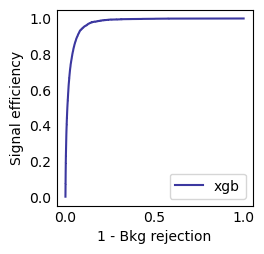

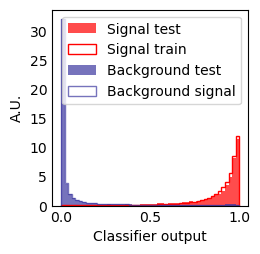

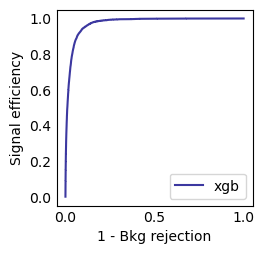

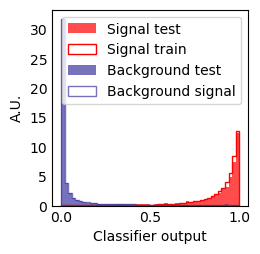

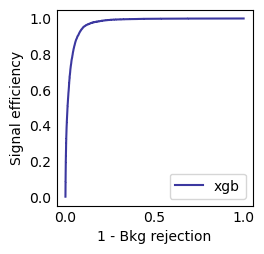

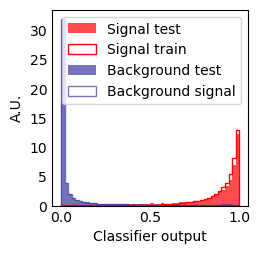

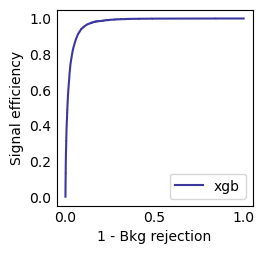

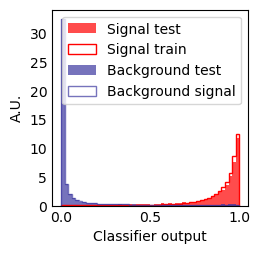

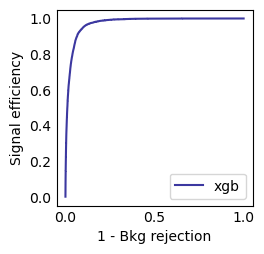

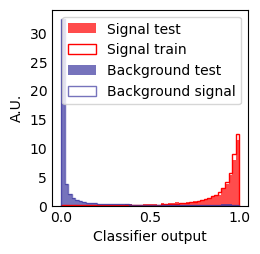

In [92]:
signal_proxy = mc_sig.query('PassSel == True')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt], axis=0, ignore_index=True)

classifiers_all = train_bdt(train_vars, signal_proxy, bkg_proxy)

In [ ]:
signal_proxy = mc_sig.query('PassEvt == True & event_type == 1')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt], axis=0, ignore_index=True)

classifiers_1 = train_bdt(train_vars, signal_proxy, bkg_proxy)

signal_proxy = mc_sig.query('PassEvt == True & event_type == 2')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt], axis=0, ignore_index=True)

classifiers_2 = train_bdt(train_vars, signal_proxy, bkg_proxy)

signal_proxy = mc_sig.query('PassEvt == True & event_type == 3')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt], axis=0, ignore_index=True)

classifiers_3 = train_bdt(train_vars, signal_proxy, bkg_proxy)

In [83]:
def predict(df, classifiers): # Define your probability threshold
    raw = df[train_vars]
    for i, bdt in enumerate(classifiers, start = 1):
        df[f'prob_sig{i}'] = bdt.predict_proba(raw)[:, 1]
        df[f'prob_bkg{i}'] = bdt.predict_proba(raw)[:, 0]
    return df

In [93]:
#classifiers = classifiers_1 + classifiers_2 + classifiers_3
classifiers = classifiers_all

data = predict(data, classifiers)

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = predict(pro , classifiers )

In [94]:
def apply_bdt_selection(df, separate = False):

    # Charge + flavor conservation
#    conserve = df['event_type'] != 0

#    angular = (delta_R(df, 1, 2) > 0.5) & (delta_R(df, 3, 4)>0.5) 

#    Zmass =  ( 
#        ((df["mz1_c1"].between(40, 120)) & (df["mz2_c1"].between(12, 120)) ) |
#        ((df["mz2_c1"].between(40, 120)) & (df["mz1_c1"].between(12, 120)) ) |
#        ((df["mz1_c2"].between(40, 120)) & (df["mz2_c2"].between(12, 120)) ) |
#        ((df["mz2_c2"].between(40, 120)) & (df["mz1_c2"].between(12, 120)) ) |
#        ((df["mz1_c3"].between(40, 120)) & (df["mz2_c3"].between(12, 120)) ) |
#        ((df["mz2_c3"].between(40, 120)) & (df["mz1_c3"].between(12, 120)) )
#    ) 

    if separate == True: 
        bdt_res_1 = df['event_type'] == 1 & (df['prob_sig1']/(df['prob_sig1']+df['prob_bkg1']) +
               df['prob_sig2']/(df['prob_sig2']+df['prob_bkg2']) +
               df['prob_sig3']/(df['prob_sig3']+df['prob_bkg3']) +
               df['prob_sig4']/(df['prob_sig4']+df['prob_bkg4']) +
               df['prob_sig5']/(df['prob_sig5']+df['prob_bkg5']) >5*0.5)

        bdt_res_2 = df['event_type'] == 2 & (df['prob_sig6']/(df['prob_sig6']+df['prob_bkg6']) +
               df['prob_sig7']/(df['prob_sig7']+df['prob_bkg7']) +
               df['prob_sig8']/(df['prob_sig8']+df['prob_bkg8']) +
               df['prob_sig9']/(df['prob_sig9']+df['prob_bkg9']) +
               df['prob_sig10']/(df['prob_sig10']+df['prob_bkg10']) >5*0.5)

        bdt_res_3 = df['event_type'] == 3 & (df['prob_sig11']/(df['prob_sig11']+df['prob_bkg11']) +
               df['prob_sig12']/(df['prob_sig12']+df['prob_bkg12']) +
               df['prob_sig13']/(df['prob_sig13']+df['prob_bkg13']) +
               df['prob_sig14']/(df['prob_sig14']+df['prob_bkg14']) +
               df['prob_sig15']/(df['prob_sig15']+df['prob_bkg15']) >5*0.5)
    
        bdt_res = bdt_res_1 | bdt_res_2 | bdt_res_3
        
    else: 
        bdt_res = (df['prob_sig1']/(df['prob_sig1']+df['prob_bkg1']) +
               df['prob_sig2']/(df['prob_sig2']+df['prob_bkg2']) +
               df['prob_sig3']/(df['prob_sig3']+df['prob_bkg3']) +
               df['prob_sig4']/(df['prob_sig4']+df['prob_bkg4']) +
               df['prob_sig5']/(df['prob_sig5']+df['prob_bkg5']) >5*0.5)
    
    # Apply final event selection mask
    df['PassBdt'] = (df['PassSel'] & bdt_res)  # you can extend with additional cuts if needed

    return df

### Apply object selection and event selection to data and each MC process###
data_obj_sel = object_selection(data)
data_evt_sel = apply_bdt_selection(data_obj_sel)

print('eff on data: ' , (data.query('PassBdt == True').shape[0]/ data.shape[0]))

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = apply_bdt_selection(object_selection(pro))

print('eff on signal: ' , (mc_higgs_11.query('PassBdt == True').shape[0]+ mc_higgs_12.query('PassBdt == True').shape[0])/(mc_higgs_11.shape[0]+mc_higgs_12.shape[0]))

eff on data:  0.011013215859030838
eff on signal:  0.6570630968548579


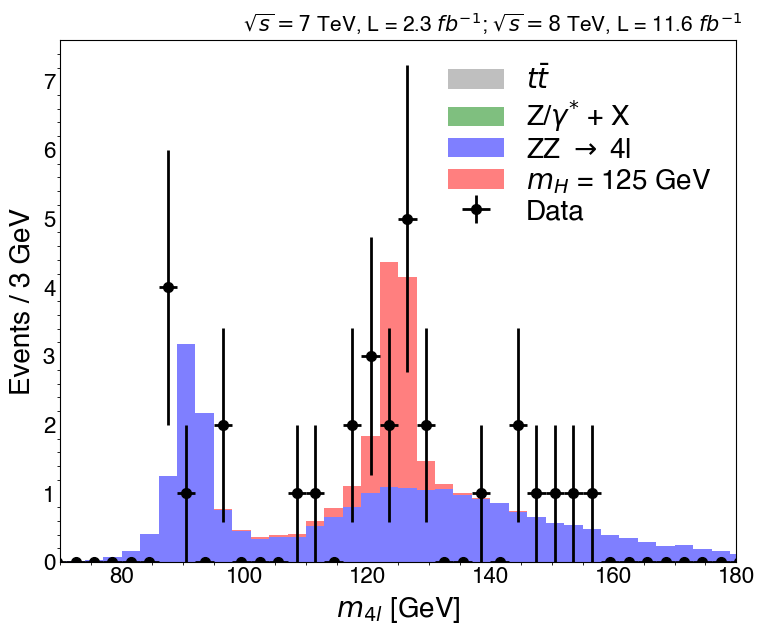

In [167]:
cut_bdt = 'PassBdt == True'

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(70,180)
plt.legend(fontsize = 20)
plt.minorticks_on()
plt.show()

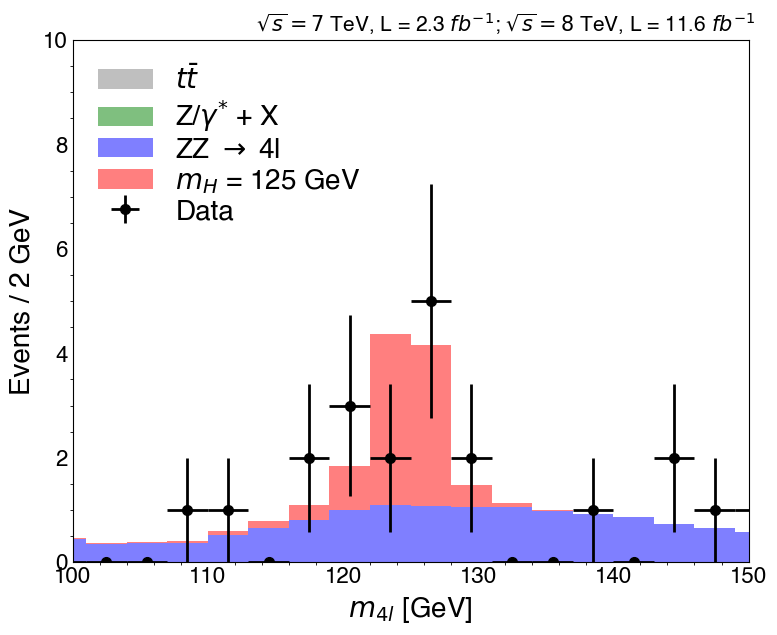

In [253]:
rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 

## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 2 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(100,150)
plt.ylim(0,10)
plt.legend(fontsize = 20, loc = 'upper left')
plt.minorticks_on()
plt.show()

In [239]:
mask = np.where((120 < bincenter) & (bincenter <130) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("s+b observed: ", np.sum(hist[mask]))

b expected:  3.5488097126277354
s expected:  7.356979492647319
s+b observed:  12


In [240]:
mask = (hist>0) & (bincenter<150) & (100<bincenter)
hist_fit = hist[mask]
hist_fit_err = np.sqrt(hist_fit)
bincenter_fit = bincenter[mask]

In [241]:
bincenter

array([ 51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,  67.,  69.,  71.,
        73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,  89.,  91.,  93.,
        95.,  97.,  99., 101., 103., 105., 107., 109., 111., 113., 115.,
       117., 119., 121., 123., 125., 127., 129., 131., 133., 135., 137.,
       139., 141., 143., 145., 147., 149., 151., 153., 155., 157., 159.,
       161., 163., 165., 167., 169., 171., 173., 175., 177., 179., 181.,
       183., 185., 187., 189., 191., 193., 195., 197., 199.])

In [242]:
import lmfit

In [243]:
def gaussian(x, mu, sigma, s):
    gauss = s * (np.exp(-(x - mu)**2 / (2* sigma**2)) / np.sqrt(2*np.pi*sigma**2)) * 2
    return gauss 

def bkg(x, b):
    bkg = b *2/(x[-1] - x[0])
    return bkg

def gaussian_w_bkg(x, mu, sigma, s, b):
    return gaussian(x,mu,sigma,s) + bkg(x,b)

In [244]:
def run_binned_fit(bin_centers, hist_ct, hist_err, model, guess):
    
    model = lmfit.Model(model)
    
    # Zip names and values into a dict
    guess_dict = dict(zip(model.param_names, guess))

    result = model.fit(hist_ct, x=bin_centers, weights=1/np.sqrt(hist_ct), **guess_dict)
    
    lmfit.report_fit(result)

    return bin_centers, hist_ct, result

In [250]:
bincenter_fit, hist_fit, result = run_binned_fit(bincenter_fit, hist_fit, hist_fit_err, gaussian_w_bkg, (125,5,7,20))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 219
    # data points      = 12
    # variables        = 4
    chi-square         = 2.00000008
    reduced chi-square = 0.25000001
    Akaike info crit   = -13.5011131
    Bayesian info crit = -11.5614865
    R-squared          = 0.54999999
[[Variables]]
    mu:     125.858071 +/- 20328.0614 (16151.58%) (init = 125)
    sigma:  0.47600976 +/- 34115.0189 (7166873.77%) (init = 5)
    s:      8.48081495 +/- 2019038.72 (23807130.89%) (init = 7)
    b:      22.8000001 +/- 3.51366522 (15.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, s)  = -1.0000
    C(mu, s)     = +1.0000
    C(mu, sigma) = -1.0000
    C(sigma, b)  = -0.3504
    C(s, b)      = +0.3504
    C(mu, b)     = +0.3504


In [251]:
#### some plotting stuff
def plot_binned_fit(bin_centers, hist_ct, fit_result, xlabel, ylabel, model):

    x_fit = np.linspace(bin_centers[0],bin_centers[-1])
    y_fit = fit_result.eval(x=x_fit)
    
    y_pred = fit_result.eval(x=bin_centers)
    y_err = np.sqrt(hist_ct)
    pull = (hist_ct - y_pred)/y_err
    
    # --- Create figure with 2 panels ---
    fig, (ax_main, ax_pull) = plt.subplots(
        2, 1, sharex=True,
        gridspec_kw={'height_ratios': [6, 1]},
        figsize=(6, 5)
    )
    
    # --- Top: data + fit ---
    ax_main.errorbar(bin_centers, hist_ct, y_err, fmt='k+', label='data')
    ax_main.plot(x_fit, y_fit, color="#BF0000", label= model +' '+'fit')
    ax_main.set_ylabel("counts")
    ax_main.legend(frameon = False)
    ax_main.annotate(r"model: $y = s\cdot\exp(- \frac{(x-\mu)^2}{2 \sigma_1^2}) + b$", xy = (0,1))
    # --- Bottom: pulls ---
    ax_pull.scatter(bin_centers, pull, color='black', marker="+", s=50)
    ax_pull.axhline(0, color='black', linestyle='-')
    ax_pull.axhline(3, color="#BF0000", linestyle='--')
    ax_pull.axhline(-3, color="#BF0000", linestyle='--')
    ax_pull.set_xlabel(xlabel)
    ax_pull.set_ylabel(r"pulls ($\sigma$)")
    ax_pull.set_ylim(-5,5)
    
    plt.tight_layout()
    plt.show()
    return fig, (ax_main, ax_pull)

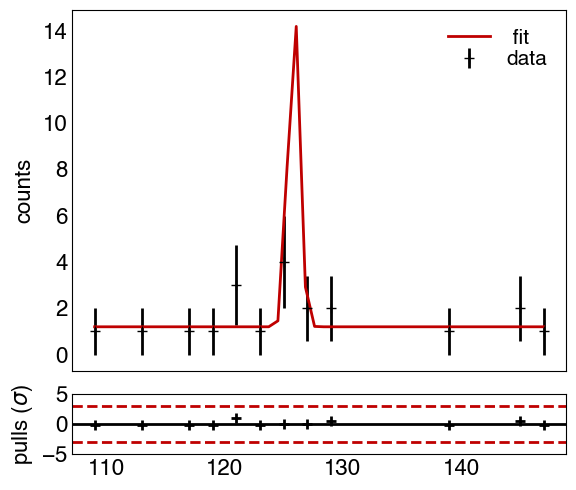

(<Figure size 600x500 with 2 Axes>,
 (<Axes: ylabel='counts'>, <Axes: ylabel='pulls ($\\sigma$)'>))

In [252]:
plot_binned_fit(bincenter_fit, hist_fit, result, xlabel=None, ylabel=None, model='')

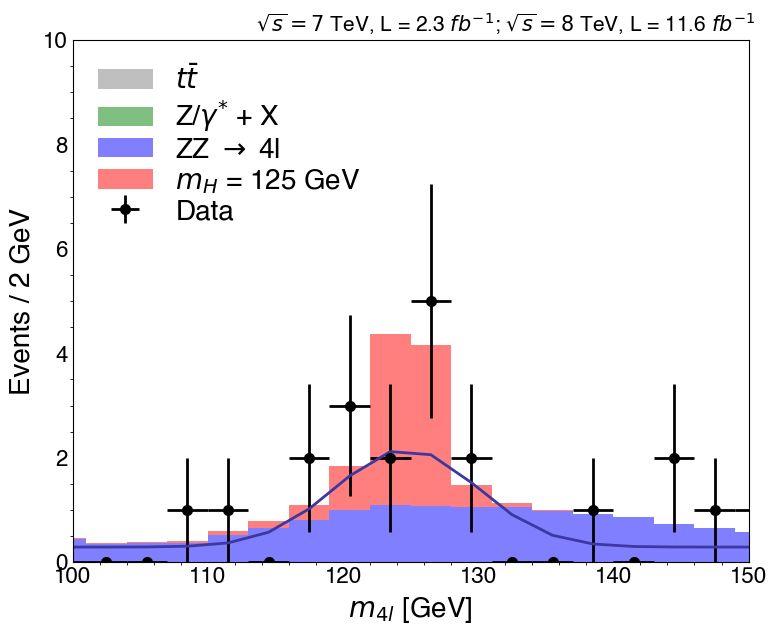

In [232]:
rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 

## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')

y_pred = result.eval(x=bincenter)
plt.plot(bincenter, y_pred)


plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 2 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(100,150)
plt.ylim(0,10)
plt.legend(fontsize = 20, loc = 'upper left')
plt.minorticks_on()
plt.show()